## 第三組 期末報告

## 組員:劉怡謙、蔡少懷、陳志翔、鄭仲延

In [ ]:
#! pip install pyvis networkx pandas pyLDAvis


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models 
import pyvis
import networkx as nx
import IPython

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 資料來源: PTT八卦版
### 時間:2023/05/01 ~ 2023/06/06
### 關鍵字:多慧、李多慧、多惠、李多惠 

In [ ]:
raw_data = pd.read_csv('./leedahye.csv')
raw_data = raw_data[raw_data.artComment != '[]']
raw_data = raw_data.sample(round(raw_data.shape[0]/4))
print(raw_data.shape)
raw_data.head()

(70, 11)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


system_id                                             artUrl  \
100        101  https://www.ptt.cc/bbs/Gossiping/M.1683511152....   
54          55  https://www.ptt.cc/bbs/Gossiping/M.1683341452....   
18          19  https://www.ptt.cc/bbs/Gossiping/M.1683003168....   
188        189  https://www.ptt.cc/bbs/Gossiping/M.1684910306....   
149        150  https://www.ptt.cc/bbs/Gossiping/M.1684073710....   

                  artTitle              artDate    artPoster artCatagory  \
100       [問卦]台女都等著看企鵝妹笑話？  2023-05-08 09:59:09  JoeGibsonJr   Gossiping   
54   [問卦]企鵝妹李多慧林襄今天三人都在桃園？  2023-05-06 10:50:50         zxc7   Gossiping   
18      [問卦]李多惠跑來南港辨公室的八掛?  2023-05-02 12:52:46     a9202507   Gossiping   
188   Re:[問卦]李多慧的場邊表情也太多了吧  2023-05-24 14:38:22       rxxken   Gossiping   
149     [問卦]多慧會回訊息企鵝妹卻不鳥人？  2023-05-14 22:15:08    flyslider   Gossiping   

                                            artContent  \
100  二世今天剛進公司 聽到女同事在聊企鵝妹\n\n他們說正在等看企鵝妹中途放棄 準備看笑話\n\...   
54   大家豪 寶傑豪\n\n企鵝妹今天會走到桃園嗎\n\n今天明天順便去樂天球場的話\n\n會不會...   
18   如題，今天沒去南港，聽說今天李多惠跑去南港某科技公司，還可以合照。\n\n有沒有在辦公室穿拉...   
188  這白眼應該不是肥不肥宅的問題\n\n肥宅是一個原因\n\n但最主要的是那個男生靠得很近 手還...   
149  話說上次去看多慧拍個照\n然後發訊息給她\n他竟然回我一個愛心\n\n反之企鵝妹 給東西 留...   

                                            artComment             e_ip  \
100  [{"cmtStatus": "→", "cmtPoster": "Golbeza", "c...      101.9.101.0   
54   [{"cmtStatus": "→", "cmtPoster": "syntax123", ...    49.216.46.177   
18   [{"cmtStatus": "推", "cmtPoster": "cuteSquirrel...   223.136.223.33   
188  [{"cmtStatus": "→", "cmtPoster": "syntax123", ...   114.27.203.108   
149  [{"cmtStatus": "→", "cmtPoster": "Howard61313"...  220.137.126.241   

            insertedDate dataSource  
100  2023-05-09 01:30:05        ptt  
54   2023-05-07 01:31:12        ptt  
18   2023-05-03 01:32:30        ptt  
188  2023-05-25 01:35:56        ptt  
149  2023-05-15 01:36:46        ptt

In [ ]:
# 移除網址格式
# 只留下中文字
raw_data["artContent"] = raw_data["artContent"].str.replace("(http|https)://.*", "", regex=True)
raw_data["artTitle"] = raw_data["artTitle"].str.replace("(http|https)://.*", "", regex=True)
raw_data["artContent"] = raw_data["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
raw_data["artTitle"] = raw_data["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
raw_data['content'] = raw_data['artContent']


raw_data = raw_data.loc[:,["artTitle","content", "artCatagory"]]  # 文章內容 文章連結
raw_data.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


artTitle                                            content  \
100       問卦台女都等著看企鵝妹笑話  二世今天剛進公司聽到女同事在聊企鵝妹他們說正在等看企鵝妹中途放棄準備看笑話可是企鵝妹現在也走...   
54   問卦企鵝妹李多慧林襄今天三人都在桃園  大家豪寶傑豪企鵝妹今天會走到桃園嗎今天明天順便去樂天球場的話會不會三人世紀同框這三人佔了近期...   
18      問卦李多惠跑來南港辨公室的八掛  如題今天沒去南港聽說今天李多惠跑去南港某科技公司還可以合照有沒有在辦公室穿拉拉隊服的八卦我肥...   

    artCatagory  
100   Gossiping  
54    Gossiping  
18    Gossiping

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")

# 新增stopwords
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

raw_data["words"] = raw_data["content"].apply(getToken)
raw_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Building prefix dict from /content/dict/dict.txt ...
DEBUG:jieba:Building prefix dict from /content/dict/dict.txt ...
Loading model from cache /tmp/jieba.u14b2ef85415a77cf73b80d3591662aec.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u14b2ef85415a77cf73b80d3591662aec.cache
Loading model cost 0.564 seconds.
DEBUG:jieba:Loading model cost 0.564 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


artTitle                                            content  \
100       問卦台女都等著看企鵝妹笑話  二世今天剛進公司聽到女同事在聊企鵝妹他們說正在等看企鵝妹中途放棄準備看笑話可是企鵝妹現在也走...   
54   問卦企鵝妹李多慧林襄今天三人都在桃園  大家豪寶傑豪企鵝妹今天會走到桃園嗎今天明天順便去樂天球場的話會不會三人世紀同框這三人佔了近期...   
18      問卦李多惠跑來南港辨公室的八掛  如題今天沒去南港聽說今天李多惠跑去南港某科技公司還可以合照有沒有在辦公室穿拉拉隊服的八卦我肥...   
188     問卦李多慧的場邊表情也太多了吧  這白眼應該不是肥不肥宅的問題肥宅是一個原因但最主要的是那個男生靠得很近手還摟過去吧當下在拍還...   
149     問卦多慧會回訊息企鵝妹卻不鳥人  話說上次去看多慧拍個照然後發訊息給她他竟然回我一個愛心反之企鵝妹給東西留建議訊息都不看似乎斗...   

    artCatagory                                              words  
100   Gossiping  [二世, 剛進, 聽到, 同事, 企鵝, 正在, 企鵝, 中途, 放棄, 準備, 笑話, 企...  
54    Gossiping  [寶傑, 企鵝, 走到, 桃園, 順便, 樂天, 球場, 三人, 世紀, 同框, 三人, 近...  
18    Gossiping  [沒去, 南港, 聽說, 李多惠, 跑去, 南港, 科技, 還可以, 合照, 辦公室, 拉拉...  
188   Gossiping  [白眼, 肥宅, 問題, 肥宅, 主要, 男生, 手還, 過去, 還能, 給日, 小文, 牡...  
149   Gossiping  [上次, 看多, 慧拍個, 訊息, 愛心, 企鵝, 妹給, 東西, 建議, 訊息, 似乎, ...

#LDA 主題模型

In [ ]:
docs = raw_data['words'].to_list()
docs[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['二世',
 '剛進',
 '聽到',
 '同事',
 '企鵝',
 '正在',
 '企鵝',
 '中途',
 '放棄',
 '準備',
 '笑話',
 '企鵝',
 '中途',
 '放棄',
 '超強',
 '吧台',
 '能夠',
 '多久',
 '心裡',
 '同事',
 '我二',
 '宅該',
 '週末',
 '企鵝',
 '直播',
 '同事',
 '現場',
 '看林襄',
 '李多慧',
 '一半',
 '週末',
 '企鵝',
 '禮拜',
 '六雙',
 '螢幕',
 '桃園',
 '球場',
 '比賽',
 '禮拜天',
 '桃園',
 '球場',
 '淹水',
 '延賽',
 '不到',
 '李多慧',
 '離題',
 '台女',
 '企鵝',
 '笑話',
 '鄉民',
 '同事',
 '八卦版',
 '清流',
 '我連去',
 '廚房',
 '泡麵',
 '平板']

##正式處理新聞

In [ ]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=4, no_above=0.99)
print(dictionary)

Dictionary<71 unique tokens: ['企鵝', '李多慧', '桃園', '現場', '球場']...>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx == 10:
        break

企鵝: 0
李多慧: 1
桃園: 2
現場: 3
球場: 4
直播: 5
鄉民: 6
多慧: 7
林襄: 8
樂天: 9
合照: 10


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pprint(" ".join(raw_data['words'].iloc[60]))


('漂亮 很帥 突然 一句 阿不 角度 神韻 類似 帽子 扣上 永遠 形象 掛勾 甩不掉 類似 國高中 同學 給你取 靠杯 綽號 以後 一輩子 早期 麻美 '
 '王仁甫 李多惠 高虹安幹 以下 開放 補充')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dictionary.doc2bow(raw_data['words'].iloc[60])[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(11, 1), (19, 1), (57, 1)]

In [ ]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]
type(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


list

In [ ]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=15, # 生成幾個主題數
    random_state=2021, # 亂數
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 查看 LDA 主題代表字

In [ ]:
ldamodel.print_topics(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(9,
  '0.144*"李多慧" + 0.094*"樂天" + 0.071*"粉絲" + 0.069*"合照" + 0.058*"韓國" + 0.053*"女孩" + 0.052*"啦啦隊" + 0.041*"女神" + 0.039*"台灣" + 0.032*"桃猿"'),
 (10,
  '0.129*"台灣" + 0.118*"林襄" + 0.083*"李多慧" + 0.066*"媒體" + 0.054*"日本" + 0.048*"新聞" + 0.038*"可愛" + 0.037*"網友" + 0.025*"企鵝" + 0.025*"現場"'),
 (6,
  '0.110*"問題" + 0.102*"貨物稅" + 0.100*"車價" + 0.056*"台灣" + 0.049*"政府" + 0.046*"關稅" + 0.046*"李多慧" + 0.036*"記得" + 0.036*"合照" + 0.036*"啦啦隊"'),
 (8,
  '0.115*"貨物稅" + 0.115*"台灣" + 0.074*"便宜" + 0.072*"關稅" + 0.072*"新聞" + 0.066*"桃園" + 0.058*"以下" + 0.050*"企鵝" + 0.044*"新車" + 0.043*"車價"'),
 (0,
  '0.173*"台灣" + 0.130*"企鵝" + 0.105*"韓國" + 0.063*"媒體" + 0.059*"女神" + 0.053*"多慧" + 0.043*"新聞" + 0.036*"徒步" + 0.035*"世界" + 0.035*"直播"'),
 (1,
  '0.135*"企鵝" + 0.121*"台灣" + 0.067*"李多慧" + 0.043*"拍照" + 0.038*"新聞" + 0.036*"貨物稅" + 0.027*"媒體" + 0.024*"便宜" + 0.024*"兩個" + 0.023*"批評"'),
 (2,
  '0.235*"企鵝" + 0.071*"李多慧" + 0.069*"討論" + 0.069*"機場" + 0.069*"林襄" + 0.056*"桃園" + 0.036*"政府" + 0.036*"球場" + 0.036*"新聞" + 0.036*"東西"'),
 (13,
  '0.211*"

#4.3 查看 LDA 模型指標

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-4.530883373121926

In [ ]:
np.exp2(-perplexity)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


23.117017520981

In [ ]:
# pmi
PMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


這個主題的 PMI score:  -0.3221888851718366


In [ ]:
PMI_model_lda.get_coherence_per_topic()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[-0.3267280229065153,
 -0.4113533621907371,
 -0.31938940311651964,
 -0.4028287764209988,
 -0.35878190633679297,
 -0.29280372749209804,
 -0.3622579442205609,
 -0.3875463169782923,
 -0.29577606599607076,
 -0.14496788315446696,
 -0.27611270583305536,
 -0.24339242518471924,
 -0.2517462805657834,
 -0.31851358551852066,
 -0.4406348716624159]

#透過指標找出最佳主題數

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 2021,
        passes=4 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


花費時間: 3.5302791595458984 sec


In [ ]:
result = pd.DataFrame(result)
result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_num  perplexity       pmi
0          2   53.629057 -0.291552
1          3   56.412559 -0.312916
2          4   57.709204 -0.303120
3          5   61.871058 -0.321219
4          6   62.466087 -0.330680
5          7   66.289948 -0.325092
6          8   66.015513 -0.315243
7          9   68.153635 -0.331374

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

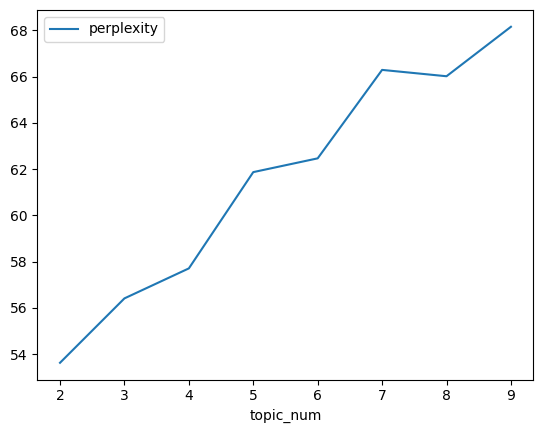

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

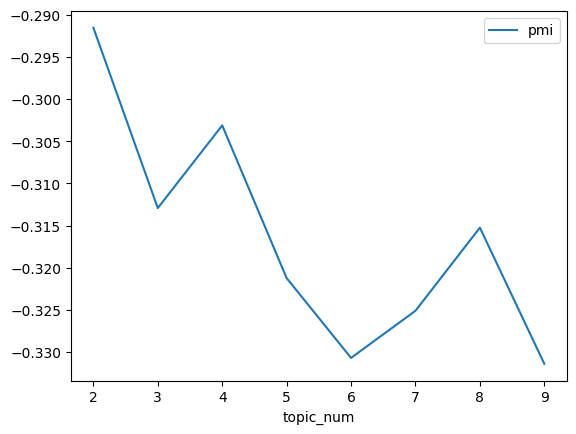

In [ ]:
result.plot.line(x='topic_num', y='pmi')

### 根據PMI及混淆度，將主題數量設定為三個。

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 82,
    passes = 10 # 訓練次數
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.063859  0.124670       1        1  51.505130
0     -0.167786 -0.018384       2        1  25.726299
2      0.103926 -0.106286       3        1  22.768571, topic_info=   Term       Freq      Total Category  logprob  loglift
0    企鵝  51.000000  51.000000  Default  30.0000  30.0000
48  貨物稅  25.000000  25.000000  Default  29.0000  29.0000
32   韓國  52.000000  52.000000  Default  28.0000  28.0000
8    林襄  16.000000  16.000000  Default  27.0000  27.0000
36   政府  10.000000  10.000000  Default  26.0000  26.0000
..  ...        ...        ...      ...      ...      ...
37   新聞   6.914003  27.692853   Topic3  -3.3436   0.0922
11  李多惠   2.876500  11.968879   Topic3  -4.2206   0.0541
48  貨物稅   5.395385  25.313039   Topic3  -3.5916  -0.0660
9    樂天   4.283236  29.438450   Topic3  -3.8224  -0.4478
0    企鵝   2.806688  51.554404   Topic3  -4.2451  -1.4308

[134 rows x 6 columns], token_table=      Topic      Freq Term
term                      
63        1  0.357012   不可
63        2  0.535518   不可
63        3  0.178506   不可
21        1  0.866279   世界
67        1  0.438794   中職
...     ...       ...  ...
46        2  0.430949   隨便
46        3  0.215474   隨便
32        1  0.950739   韓國
32        3  0.038030   韓國
33        1  0.962506  韓國人

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

### 根據上圖，我們發現在資料蒐集期間內，跟多慧相關的主題大致可分為三類。<br>第一類是和近期來台徒步環島的企鵝妹做比較。<br>第二類是和熱天桃園啦啦隊中同樣具有高知名度的林襄首度同台的相關討論。<br>最後一類則是與李多慧自身相關的新聞。

### 接下來對於資料集文章底下的推噓文進行社群媒體分析

In [ ]:
raw_data = pd.read_csv('./leedahye.csv')
raw_data = raw_data[raw_data.artComment != '[]']
raw_data = raw_data.sample(round(raw_data.shape[0]/8))
print(raw_data.shape)
raw_data.head()

(35, 11)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


system_id                                             artUrl  \
194        195  https://www.ptt.cc/bbs/Gossiping/M.1684980646....   
167        168  https://www.ptt.cc/bbs/Gossiping/M.1684587630....   
165        166  https://www.ptt.cc/bbs/Gossiping/M.1684581277....   
221        222  https://www.ptt.cc/bbs/Gossiping/M.1685295596....   
138        139  https://www.ptt.cc/bbs/Gossiping/M.1683829387....   

                       artTitle              artDate  artPoster artCatagory  \
194  Re:[新聞]不只鄭家純！傳綠委還點名林襄和陳沂　他  2023-05-25 10:10:44  benson867   Gossiping   
167             [問卦]驚!?李多慧人氣下跌?  2023-05-20 21:00:21  dahanjian   Gossiping   
165        [問卦]有人會為專看啦啦隊去現場看球嗎?  2023-05-20 19:14:35     rexlin   Gossiping   
221      Re:[問卦]是不是只有華人才滿腦子都是錢？  2023-05-29 01:39:51    protoss   Gossiping   
138     Re:[問卦]企鵝妹李多慧林襄的腿哪個比較有料  2023-05-12 02:23:04    protoss   Gossiping   

                                            artContent  \
194  弱爆了\n\n你推的那些人一點知名度都沒有\n\n我心目中有兩位民進黨想要重返農藥的最佳名單...   
167  八卦肥北鼻處男宅 大給賀\n\n先上多慧美圖\nhttps://i.imgur.com/94...   
165  4這樣的~\n\n最近在水管上看到很多啦啦隊應援影片\n\n想問大家會為了啦啦隊去現場看球否...   
221  華人本來層次就真的是比較低沒錯...\n\n    記得好像有看過酷炫開著跑車載著好像是他親...   
138  企鵝妹那圖根本就歐美背包客的模樣...\n\n    那腿算好看的了...\n\n    見...   

                                            artComment             e_ip  \
194  [{"cmtStatus": "→", "cmtPoster": "ZhouGongJin"...    111.240.9.131   
167  [{"cmtStatus": "推", "cmtPoster": "leo1990910",...   220.142.77.104   
165  [{"cmtStatus": "→", "cmtPoster": "johnson2726"...    114.37.110.83   
221  [{"cmtStatus": "推", "cmtPoster": "marktak", "c...  180.176.130.101   
138  [{"cmtStatus": "→", "cmtPoster": "kuosambition...  180.176.130.101   

            insertedDate dataSource  
194  2023-05-26 01:32:33        ptt  
167  2023-05-21 01:43:59        ptt  
165  2023-05-21 01:42:35        ptt  
221  2023-05-30 01:27:22        ptt  
138  2023-05-13 01:35:57        ptt

### 首先把推噓文整理出來，並找出哪天討論最熱絡

In [ ]:
#parse comment

def getComtInfo(com):
  cmters,cmt_statuss = [],[]
  com = eval(com)
  for i in com:
    print(i)
    cmters.append(i['cmtPoster'])
    cmt_statuss.append(i['cmtStatus'])
  return pd.Series([cmters, cmt_statuss])

raw_data[['artComter','artStatus']] = raw_data['artComment'].apply(lambda r: getComtInfo(r))

In [ ]:
raw_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


system_id                                             artUrl  \
194        195  https://www.ptt.cc/bbs/Gossiping/M.1684980646....   
167        168  https://www.ptt.cc/bbs/Gossiping/M.1684587630....   
165        166  https://www.ptt.cc/bbs/Gossiping/M.1684581277....   
221        222  https://www.ptt.cc/bbs/Gossiping/M.1685295596....   
138        139  https://www.ptt.cc/bbs/Gossiping/M.1683829387....   
273        274  https://www.ptt.cc/bbs/Gossiping/M.1685951093....   
152        153  https://www.ptt.cc/bbs/Gossiping/M.1684305984....   
104        105  https://www.ptt.cc/bbs/Gossiping/M.1683517632....   
207        208  https://www.ptt.cc/bbs/Gossiping/M.1685089507....   
10          11  https://www.ptt.cc/bbs/Gossiping/M.1682966433....   
209        210  https://www.ptt.cc/bbs/Gossiping/M.1685111971....   
146        147  https://www.ptt.cc/bbs/Gossiping/M.1683906296....   
137        138  https://www.ptt.cc/bbs/Gossiping/M.1683827642....   
211        212  https://www.ptt.cc/bbs/Gossiping/M.1685115919....   
14          15  https://www.ptt.cc/bbs/Gossiping/M.1682997322....   
195        196  https://www.ptt.cc/bbs/Gossiping/M.1684981090....   
254        255  https://www.ptt.cc/bbs/Gossiping/M.1685508287....   
107        108  https://www.ptt.cc/bbs/Gossiping/M.1683545821....   
3            4  https://www.ptt.cc/bbs/Gossiping/M.1682921740....   
219        220  https://www.ptt.cc/bbs/Gossiping/M.1685289029....   
11          12  https://www.ptt.cc/bbs/Gossiping/M.1682994655....   
255        256  https://www.ptt.cc/bbs/Gossiping/M.1685508860....   
109        110  https://www.ptt.cc/bbs/Gossiping/M.1683546179....   
93          94  https://www.ptt.cc/bbs/Gossiping/M.1683462632....   
60          61  https://www.ptt.cc/bbs/Gossiping/M.1683365905....   
40          41  https://www.ptt.cc/bbs/Gossiping/M.1683181918....   
147        148  https://www.ptt.cc/bbs/Gossiping/M.1683978749....   
54          55  https://www.ptt.cc/bbs/Gossiping/M.1683341452....   
235        236  https://www.ptt.cc/bbs/Gossiping/M.1685489822....   
97          98  https://www.ptt.cc/bbs/Gossiping/M.1683467387....   
64          65  https://www.ptt.cc/bbs/Gossiping/M.1683369414....   
89          90  https://www.ptt.cc/bbs/Gossiping/M.1683451630....   
49          50  https://www.ptt.cc/bbs/Gossiping/M.1683268277....   
237        238  https://www.ptt.cc/bbs/Gossiping/M.1685490454....   
188        189  https://www.ptt.cc/bbs/Gossiping/M.1684910306....   

                         artTitle              artDate     artPoster  \
194    Re:[新聞]不只鄭家純！傳綠委還點名林襄和陳沂　他  2023-05-25 10:10:44     benson867   
167               [問卦]驚!?李多慧人氣下跌?  2023-05-20 21:00:21     dahanjian   
165          [問卦]有人會為專看啦啦隊去現場看球嗎?  2023-05-20 19:14:35        rexlin   
221        Re:[問卦]是不是只有華人才滿腦子都是錢？  2023-05-29 01:39:51       protoss   
138       Re:[問卦]企鵝妹李多慧林襄的腿哪個比較有料  2023-05-12 02:23:04       protoss   
273         [問卦]為什麼樂天不多設計電臀動作給李多慧  2023-06-05 15:44:51     ss61512tw   
152         [問卦]峮峮為什麼不出來教育林襄和李多慧?  2023-05-17 14:46:22    taipei5566   
104       [新聞]郭台銘不會講台語硬要講、曾馨瑩也現身　  2023-05-08 11:47:10       Kazmier   
207        [問卦]李多惠舞蹈是不是碾壓台灣啦啦隊任何一  2023-05-26 16:25:05         signm   
10                [問卦]所以還有人car君君嗎  2023-05-02 02:40:31       xiikjuy   
209             [問卦]樂天女孩強制踢一個，踢誰？  2023-05-26 22:39:27  generalfungi   
146            [問卦]超商下一個配合的網紅會是誰?  2023-05-12 23:44:54       e191915   
137          [問卦]企鵝妹李多慧林襄的腿哪個比較有料  2023-05-12 01:54:00      ggian123   
211                  [問卦]Q口Q李多慧受傷  2023-05-26 23:45:16     macassans   
14        [問卦]全世界有其他國家比台灣更適合女性生活嗎  2023-05-02 11:15:20        kaitai   
195       [新聞]樂天女孩總選舉林襄意外止步16強李多慧  2023-05-25 10:18:07   jumpdog5566   
254    Re:[新聞]高嘉瑜：李多慧買韓國產車只花40萬元台  2023-05-31 12:44:45       jimgene   
107       [新聞]同框破謠言！李多慧告白林襄「超喜歡妳」  2023-05-08 19:36:59   sweat992001   
3          [問卦]企鵝/多慧/莎莎為何新聞版面差很大？  2023-05-01 14:15:36    weber18767   
219      Re:[問卦]李多惠在韓國買新車只要四十萬台幣？  2023-05-28 23:50:27       PPAPwww   
11      

In [ ]:
raw_data = raw_data.explode(['artComter','artStatus'])
socail_data = raw_data[['artUrl','artPoster','artComter','artStatus']]
socail_data.head(10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


artUrl  artPoster  \
194  https://www.ptt.cc/bbs/Gossiping/M.1684980646....  benson867   
194  https://www.ptt.cc/bbs/Gossiping/M.1684980646....  benson867   
194  https://www.ptt.cc/bbs/Gossiping/M.1684980646....  benson867   
194  https://www.ptt.cc/bbs/Gossiping/M.1684980646....  benson867   
194  https://www.ptt.cc/bbs/Gossiping/M.1684980646....  benson867   
167  https://www.ptt.cc/bbs/Gossiping/M.1684587630....  dahanjian   
167  https://www.ptt.cc/bbs/Gossiping/M.1684587630....  dahanjian   
167  https://www.ptt.cc/bbs/Gossiping/M.1684587630....  dahanjian   
167  https://www.ptt.cc/bbs/Gossiping/M.1684587630....  dahanjian   
167  https://www.ptt.cc/bbs/Gossiping/M.1684587630....  dahanjian   

       artComter artStatus  
194  ZhouGongJin         →  
194    antony999         推  
194        hoesi         推  
194    cobras638         →  
194     shiaowei         推  
167   leo1990910         推  
167       johnwu         噓  
167    chugliang         →  
167       VSshow         推  
167  ralfeistein         推

In [ ]:
socail_data.artStatus.unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['→', '推', '噓'], dtype=object)

In [ ]:
# 建立邊的資料
import random


po_df = socail_data[['artPoster','artUrl']].drop_duplicates().rename(columns = {'artPoster':'src','artUrl':'dis'})
sample_url = random.choices(po_df.dis.unique().tolist(),k=300)
po_df = po_df[po_df.dis.isin(sample_url)]
re_df = socail_data[['artComter','artUrl','artStatus']].rename(columns = {'artComter':'src','artUrl':'dis','artStatus':'weight'})
re_df = re_df[re_df.dis.isin(sample_url)]
re_df = re_df[~re_df['src'].isna()]



def convertStatus(s):
  if s == '推':
    return 2
  elif s == '→':
    return 1
  else :
    return -1
re_df['weight'] = re_df['weight'].map(convertStatus)
re_df = re_df.groupby(['src','dis']).sum().reset_index()

# 設定分數低的為紅色
def getColor(w):
  if w>0:
    return 'green'
  else:
    return 'red'
re_df['color'] = re_df.weight.map(getColor)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 人為綠色節點
# po文為橘色節點

netWork = pyvis.network.Network(notebook=True, cdn_resources='in_line',directed=True)
netWork.encoding = 'uft-8-sig'
person = list(set(po_df.src.unique().tolist()+re_df.src.unique().tolist()))
url = po_df.dis.unique().tolist()
netWork.add_nodes(
    nodes = person,
    value = [1 for i in range(len(person))],
    color = ['#66CDAA' for i in range(len(person))],
    title = person
)
netWork.add_nodes(
    nodes = url,
    value = [2 for i in range(len(url))],
    color = ['#FFB366' for i in range(len(url))],
    title = url
)
for i in po_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color='grey')
for i in re_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color=i[3])

# 設定layout
netWork.repulsion()

# netWork.toggle_physics(True)
# netWork.set_options("""
# const options = {
#   "physics": {
#     "forceAtlas2Based": {
#       "springLength": 100
#     },
#     "minVelocity": 0.75,
#     "solver": "forceAtlas2Based",
#     "timestep": 0.48
#   }
# }
# """)

netWork.show("./basic_netWork.html")
IPython.display.HTML('basic_netWork.html')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


./basic_netWork.html


In [ ]:
pos_cmt = socail_data.copy()
pos_cmt = pos_cmt[~pos_cmt.artComter.isna()]
pos_cmt.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


artUrl  artPoster  \
194  https://www.ptt.cc/bbs/Gossiping/M.1684980646....  benson867   
194  https://www.ptt.cc/bbs/Gossiping/M.1684980646....  benson867   
194  https://www.ptt.cc/bbs/Gossiping/M.1684980646....  benson867   
194  https://www.ptt.cc/bbs/Gossiping/M.1684980646....  benson867   
194  https://www.ptt.cc/bbs/Gossiping/M.1684980646....  benson867   
167  https://www.ptt.cc/bbs/Gossiping/M.1684587630....  dahanjian   
167  https://www.ptt.cc/bbs/Gossiping/M.1684587630....  dahanjian   
167  https://www.ptt.cc/bbs/Gossiping/M.1684587630....  dahanjian   
167  https://www.ptt.cc/bbs/Gossiping/M.1684587630....  dahanjian   
167  https://www.ptt.cc/bbs/Gossiping/M.1684587630....  dahanjian   

       artComter artStatus  
194  ZhouGongJin         →  
194    antony999         推  
194        hoesi         推  
194    cobras638         →  
194     shiaowei         推  
167   leo1990910         推  
167       johnwu         噓  
167    chugliang         →  
167       VSshow         推  
167  ralfeistein         推

In [ ]:
pos_cmt['score'] = pos_cmt['artStatus'].apply(lambda r: convertStatus(r))
pos_cmt = pos_cmt.groupby(['artComter','artPoster']).sum('score').reset_index()
pos_cmt = pos_cmt[pos_cmt.score>=0]
pos_cmt = pos_cmt[pos_cmt.artComter != pos_cmt.artPoster]
# pos_cmt.score = 1
pos_cmt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


artComter     artPoster  score
1         A80211ab     macassans      2
2        AFROGUNSO       Kazmier      2
3        AGATELINK     afa5644ti      3
4         ALIENKUO  generalfungi      2
5           ALOVET   jumpdog5566      2
...            ...           ...    ...
1060         zscst       Kazmier      3
1061        zvx911  generalfungi      2
1062  zweihander99       Kazmier      1
1063          zwwz       Kazmier      2
1065        zzff92       Kazmier      4

[950 rows x 3 columns]

In [ ]:
pers = np.unique(pos_cmt[['artComter', 'artPoster']])
mat = pd.pivot_table(pos_cmt,index = 'artComter', columns = 'artPoster' ,values='score' ).fillna(0)\
  .reindex(columns=pers, index=pers, fill_value=0).to_numpy()
print(mat.shape)
tri = (np.tril(mat,-1).T + np.triu(mat,1))
mat_s = tri+tri.T
# # print((mat == mat.transpose()).all())

# G = nx.DiGraph(mat)
# G_sub = sorted(nx.connected_components(G), key=len, reverse=True)
# G_max_sub = G.subgraph(G_sub[0])
# # 重新定義 mat
# mat = nx.adjacency_matrix(G_max_sub).todense()
# node_idx = list(G_max_sub.nodes)
# # mat = mat[np.ix_(node_idx,node_idx)]
# pers = pers[node_idx]
# print((mat == mat.transpose()).all())

# # 計算無向圖的adj


(843, 843)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def random_color():
  r = lambda: random.randint(0,255)
  return '#%02X%02X%02X' % (r(),r(),r())

def matPresentGraph(mat:np.array,node_id:list,node_type:list=None,node_value:list = None,directed = True,edge_color=None) -> pyvis.network.Network:

  if directed != True:
    if (mat == mat.transpose()).all():
      print('matrix is Symmetric')
    else:
      print('matrix is not Symmetric')
  if node_type == None:
    c = random_color()
    node_colors = [c for i in range(len(node_id))]
    node_type = [" " for i in range(len(node_id))]
  else:
    node_color_map = {}
    for i in set(node_type):
      while True:
        c = random_color()
        if c not in node_color_map.values():
          break
      node_color_map[i] = c
    node_colors = [node_color_map[i] for i in node_type]
  # print(node_colors)
  if edge_color == None:
    edge_color = random_color()
  edge_color = random_color()
  if node_value == None:
    node_value = [1 for i in range(len(node_id))]

  net = pyvis.network.Network(notebook=True, directed = directed, cdn_resources='in_line')
  
  titles_list = []
  for i ,j in zip(node_id,node_type):
    titles_list.append(str(i)+":"+str(j))

  net.add_nodes(
      nodes = node_id,
      value = node_value,
      label = node_id,
      title = titles_list,
      color = node_colors
  )

  for row in range(len(node_id)):
    for col in range(len(node_id)):
      if mat[row][col]>0.:
        net.add_edge(
            node_id[row],node_id[col],width = mat[row][col],color = edge_color,title = mat[row][col]
        )
  net.repulsion()
  return net


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 定義發文者（po）、評論者(cmt)、兩者兼具(both)
node_type = []

cmt_list = pos_cmt['artComter'].unique().tolist()
po_list = pos_cmt['artPoster'].unique().tolist()
both_list = list(set(cmt_list) & set(po_list))
for p in pers:
  if p in both_list:
    node_type.append('both')

  elif p in cmt_list:
    node_type.append('cmt')

  elif p in po_list:
    node_type.append('po')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

eigenvec = np.array(list(nx.eigenvector_centrality(nx.Graph(mat_s),max_iter = 10000).values()))
eigenvec = (eigenvec-np.min(eigenvec))/(np.max(eigenvec)-np.min(eigenvec))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
q = np.quantile(eigenvec,[.2,.4,.6,.8])
q

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([5.71440048e-05, 3.94510929e-04, 1.88183262e-03, 6.40985533e-02])

In [ ]:
# Digraph 設定有向圖
pagerank = np.array(list(nx.pagerank(nx.DiGraph(mat)).values()))
# pagerank = (pagerank-np.min(pagerank))/(np.max(pagerank)-np.min(pagerank))
pagerank

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062691,
       0.00062691, 0.00062691, 0.00062691, 0.00062691, 0.00062

In [ ]:
net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=(pagerank*1000).tolist())
net.show("./pers_page_netWork.html")
IPython.display.HTML('pers_page_netWork.html')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


./pers_page_netWork.html


In [ ]:
out_,in_ = nx.hits(nx.DiGraph(mat),max_iter=100)
out_,in_ = np.array(list(out_.values())),np.array(list(in_.values()))
out_ = (out_-np.min(out_))/(np.max(out_)-np.min(out_))
in_ = (in_-np.min(in_))/(np.max(in_)-np.min(in_))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
in_q = np.quantile(in_,[.2,.4,.6,.8])
out_q = np.quantile(out_,[.2,.4,.6,.8])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
node_value = []


for i in out_:
  if i > out_q[3]:
    node_value.append(25)
  elif i >out_q[2]:
    node_value.append(20)
  elif i>out_q[1]:
    node_value.append(15)
  elif i>out_q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=node_value)
net.show("./pers_out_netWork.html")
IPython.display.HTML('pers_out_netWork.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


./pers_out_netWork.html


In [ ]:
node_value = []
for i in in_:
  if i > in_q[3]:
    node_value.append(25)
  elif i >in_q[2]:
    node_value.append(20)
  elif i>in_q[1]:
    node_value.append(15)
  elif i>in_q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=node_value)
net.show("./pers_in_netWork.html")
IPython.display.HTML('pers_in_netWork.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


./pers_in_netWork.html


In [ ]:
bet = np.array(list(nx.betweenness_centrality(nx.Graph(mat_s)).values()))
bet = (bet-np.min(bet))/(np.max(bet)-np.min(bet))
bet_q = np.quantile(bet,[.2,.4,.6,.8])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
node_value = []
for i in bet:
  if i > bet_q[3]:
    node_value.append(25)
  elif i > bet_q[2]:
    node_value.append(20)
  elif i>bet_q[1]:
    node_value.append(15)
  elif i>bet_q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=node_value)
net.show("./pers_bet_netWork.html")
IPython.display.HTML('pers_bet_netWork.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


./pers_bet_netWork.html


In [ ]:
# 計算max subgraph
G = nx.Graph(mat_s)
G_sub = sorted(nx.connected_components(G), key=len, reverse=True)
G_max_sub = G.subgraph(G_sub[0])
# # 重新定義 mat
sub_mat = nx.adjacency_matrix(G_max_sub).todense()
node_idx = list(G_max_sub.nodes)
sub_pers = pers[node_idx]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
net = matPresentGraph(mat=sub_mat,node_id=sub_pers,directed=False)
net.show("./max_sub.html")
IPython.display.HTML('max_sub.html')

matrix is Symmetric


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


./max_sub.html


In [ ]:
print('transitivity: ',nx.transitivity(nx.Graph(sub_mat)),'\n','density: ',nx.density(nx.Graph(sub_mat)),'\n','diameter: ',nx.diameter(nx.Graph(sub_mat)),'\n','average_clustering: ',nx.average_clustering(nx.Graph(sub_mat)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


transitivity:  0.00041102459297147944 
 density:  0.002815116961774976 
 diameter:  10 
 average_clustering:  0.002351428470656073
